<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/C%C3%B3pia_de_In%C3%ADcio_Pinn_inversa_Burgers_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Inverse PINNs - Burgers

Bibliotecas

In [11]:
import torch
import torch.autograd as autograd         #AD, diferenciação automática
from torch import Tensor
import torch.nn as nn                     #rede neural
import torch.optim as optim               #otimizadores
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
import numpy as np
import time
import scipy.io

#Padronizando o tipo dos valores
torch.set_default_dtype(torch.float)
torch.manual_seed(1234) #Uma semente para os valores, evitando a geração aleatória
np.random.seed(1234)

#Esse aqui não sei bem, mas sempre usam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())


cpu


In [12]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig = plt.figure(figsize=(8,6))
  ax = fig.add_subplot(111)
  cp = ax.contourf(T,X, F_xt,20,cmap="jet")
  fig.colorbar(cp)
  ax.set_title('U(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  fig = plt.figure(figsize=(10,12))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(T, X, F_xt, cmap='jet');
  ax.view_init(25,25)
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('u(t,x)')
  ax.set_title('Solução exata da equação de Burger - dados fornecidos');
  plt.show()

In [22]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [21]:
def solutionplot(u_pred,X_u_train,u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow',
                extent=[T.min(), T.max(), X.min(), X.max()],
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 0.5, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('u(x,t)', fontsize = 10)

    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_title('u(x,t)', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('u(x,t)', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('u(x,t)', fontsize = 10)

    plt.savefig('Burgers-Inverse.png',dpi = 500)

#Descrição do Problema

Criação de uma rede neural para problema inverso da equação de Burger, conforme:

  $\frac{\partial u}{\partial t} + λ_1u\frac{\partial u}{\partial x} = λ_2\frac{\partial^2 u}{\partial x^2}$

  $ x \in [-1,1]$

  $ t \in [0,1] $

  com os valores reais de $λ_1 = 1$ e $\lambda _2 = 𝜈 = \frac{0.01}{π}$

  **Em problemas diretos**, tinha-se: Modelos → Dados (previsão)

  Já em **problemas inversos**, têm-se: Dados → Modelo (obter os parâmetros do modelo)

#PINNS para problemas inversos -- "Data-driven Discovery of Nonlinear Partial Differential Equations"

**Problemas Inversos**: Dados → Parâmetros do modelo:

Dados → PINN → Parâmetros do modelo, que neste caso são os parâmetros da Equação diferencial parcial

Em Raissi *et al*, (2017) é dito que a forma geral das equações diferenciais parciais não lineares e parametrizadas é:

$u_t + 𝞕[u;λ] = 0$

com $u_t$ sendo a solução e $ 𝞕[u;λ]$ um operador não linear parametrizado por $λ$.

Ou seja, a PINN é utilizada para obter λ.

###Pelo teorema da aproximação universal, as redes neurais podem ser utilizadas para aproximar qualquer função. (https://book.sciml.ai/notes/03/)

Sendo a rede neural descrita pela equação:

$N(X) = W_nσ_{n-1}(W_{n-1}σ_{n-2}(...(W_2σ(W_1X + b_1) + b_2) + ...) + b_{n-1}) + b_n$

Do teorema podemos assumir então que:

$N(x,t) ≈ u(x,t)$

Logo:

$N_t + λ_1NN_x - λ_2N_{xx} ≈ u_t + λ_1uu_x - λ_2u_{xx} = 0$

A função $f$ é portanto:

$f(x,t) = N_t + λ_1NN_x - λ_2N_{xx} = N_t + Ζ[N, λ] ≈ 0$

###Custo - Loss

Para a pinn inversa, é definido um certo número de pontos dentro do domínio ($N_u$) o qual é verificado o valor da função $f$ nesses pontos, e em seguida minimizado o erro associado ao valor predito e o real, por meio da equação:

$MSE_f = \frac{1}{N_u}∑^{N_u}_{i=1}|f(t_u^i, x_u^i)|^2$

Por se tratar de um problema inverso, os dados são conhecidos, assim, o segundo custo é da forma:

$MSE_u = \frac{1}{N_u}∑^{N_u}_{i=1}|u(t_u^i, x_u^i) - N(t^i_u, x_u^i)|^2$

$MSE_{total} = MSE_f + MSE_u$

Parâmetros

In [13]:
itr=20000
lr=0.1
camadas = np.array([2,20,20,20,20,20,20,20,20,1]) #2 nós de entradas, 8 camadas ocultas contendo 20 nós por camadas e uma saída
N_u = 100 #Número total de pontos de dados para 'u'
N_f = 10000 # Número total de pontos de colocação
nu = 0.01/np.pi #Coeficiente de difusão

In [14]:
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__()

        #Função de ativação
        self.activation = nn.Tanh()

        #Criando a rede neural
        self.linears = nn.ModuleList([nn.Linear(camadas[i], camadas[i+1]) for i in range(len(camadas)-1)])

        #inicialização normal
        for i in range(len(camadas)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            #Setando os viéses para zero, deixando apenas o parâmetro lambda
            nn.init.zeros_(self.linears[i].bias.data)

    #propagação direta
    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        #Normalizando os dados
        x = (x - l_b)/(u_b - l_b)

        a = x.float()

        for i in range(len(camadas)-2):

            z = self.linears[i](a)
            a = self.activation(z)

        a = self.linears[-1](a)
        return a

In [15]:
lambda1=5.0
lambda2=0.2
print("O real 𝜆 = [", 1.0,nu,"]. O palpite dado é de 𝜆 _PINN= [",lambda1,lambda2,"]")

O real 𝜆 = [ 1.0 0.003183098861837907 ]. O palpite dado é de 𝜆 _PINN= [ 5.0 0.2 ]


In [16]:
class Rede():
    def __init__(self, camadas):
        self.mse = nn.MSELoss(reduction ='mean')
        self.itr = 0 #contador de itração

        self.lambda1 = torch.tensor([lambda1], requires_grad=True).float().to(device)  #nicialização dos novos parâmetros, ou seja, 𝜆 (problema inverso)
        self.lambda2 = torch.tensor([lambda2], requires_grad=True).float().to(device)

        self.lambda1 = nn.Parameter(self.lambda1) #Aqui está setando ele como parametro (https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter)
        self.lambda2 = nn.Parameter(self.lambda2)

        self.dnn = DNN(camadas).to(device)
        self.dnn.register_parameter('lambda1', self.lambda1)  #Registrando como parâmetro da rede neural
        self.dnn.register_parameter('lambda2', self.lambda2)


    def custo_dados(self,x,y):
        loss_u = self.mse(self.dnn(x), y)
        return loss_u

    def custo_EDP(self, X_treino_nu):
        lambda1=self.lambda1
        lambda2=self.lambda2

        g = X_treino_nu.clone() #Criando uma cópia do vetor com os dados de treino
        g.requires_grad = True

        u = self.dnn(g) #Fazendo a predição

        u_x_t = autograd.grad(u,g,torch.ones([X_treino_nu.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]  #Derivando em primeira ordem
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(X_treino_nu.shape).to(device), create_graph=True)[0] #Derivando em segunda ordem

        u_x = u_x_t[:,[0]] #Separando as derivadas no tempo e espaço
        u_t = u_x_t[:,[1]]
        u_xx = u_xx_tt[:,[0]]

        f = u_t + (lambda1)*(self.dnn(g))*(u_x) - (lambda2)*u_xx  #Função que queremos minimizar

        loss_f = self.mse(f,f_hat)

        return loss_f

    def erro(self,x,y):

        loss_u = self.custo_dados(x,y)
        loss_f = self.custo_EDP(x)

        loss_val = loss_u + loss_f
        return loss_val


    def treino(self): #modificação dos parâmetros

        otimizador.zero_grad()

        erro = self.erro(X_treino_nu, U_treino_nu)

        erro.backward()

        self.itr += 1

        if self.itr % 10 == 0:

            error_vec, _ = PINN.test()

            print(
                'Erro Relativo: %.5f , 𝜆_real = [1.0,  %.5f], 𝜆_PINN = [%.5f,  %.5f]' %
                (
                    error_vec.cpu().detach().numpy(),
                    nu,
                    self.lambda1.item(),
                    self.lambda2.item()))


        return erro

    'Teste da rede neural'
    def test(self):

        u_pred = self.dnn(X_real)

        error_vec = torch.linalg.norm((U_real-u_pred),2)/torch.linalg.norm(U_real,2) #Norma L2 do erro
        u_pred = u_pred.cpu().detach().numpy()

        u_pred = np.reshape(u_pred,(x.shape[0],t.shape[0]),order='F')

        return error_vec, u_pred

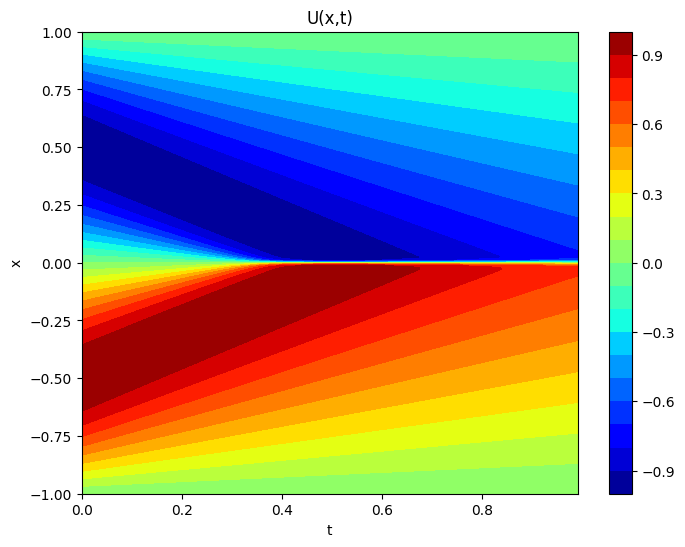

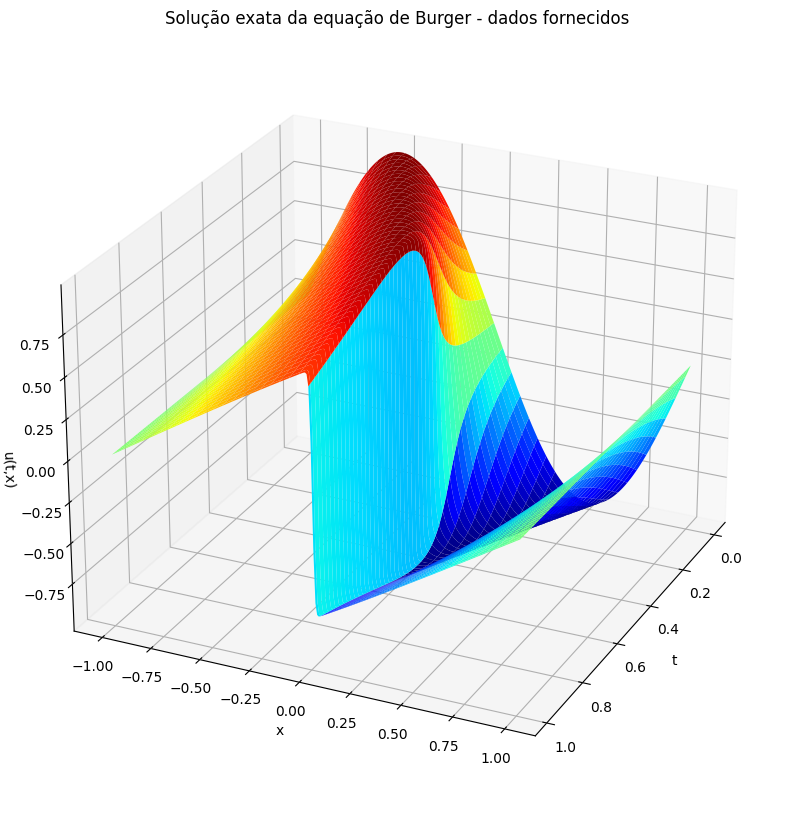

In [17]:
dados = scipy.io.loadmat('burgers_shock.mat') #Fornecido pelo Maziar
x = dados['x'] #256 pontos indo de -1 até 1
t = dados['t'] #100 pontos indo de 0 a 1
usol = dados['usol'] #Solução [256x100]

X, T = np.meshgrid(x,t) #Faz 2 matrizes X e T tais que u(X[i],T[j])=usol[i][j] são uma tupla
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) #Plotando a solução exata

In [18]:
#Preparação dos dados
X_real = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
U_real = usol.flatten('F')[:,None]

#Máximo e mínimo do domínio
lb = X_real[0]
ub = X_real[-1]

qtd_pontos=len(x)*len(t)

#Obtenção aleatória dos pontos de colocação
id_f = np.random.choice(qtd_pontos, N_f, replace=False)
X_treino_nu = X_real[id_f]
U_treino_nu= U_real[id_f]

#Conversão dos arrays em tensores e enviando-os para a GPU
X_treino_nu = torch.from_numpy(X_treino_nu).float().to(device)
U_treino_nu = torch.from_numpy(U_treino_nu).float().to(device)
X_real = torch.from_numpy(X_real).float().to(device)
U_real = torch.from_numpy(U_real).float().to(device)
f_hat = torch.zeros(X_treino_nu.shape[0],1).to(device)

In [19]:
PINN = Rede(camadas)

params = list(PINN.dnn.parameters())

In [20]:
#Otimizador L-BFGS-B
otimizador = torch.optim.LBFGS(params, lr,
                              max_iter = 50000,
                              max_eval = None,
                              tolerance_grad = 1e-11,
                              tolerance_change = 1e-11,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

otimizador.step(PINN.treino)


elapsed = time.time() - start_time
print('Tempo de treino: %.2f' % (elapsed))


#Acurácia do modelo
error_vec, u_pred = PINN.test()

print('Erro do teste: %.5f'  % (error_vec))

Erro Relativo: 0.91251 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.99975,  0.19877]
Erro Relativo: 0.89758 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.97851,  0.18760]
Erro Relativo: 0.89752 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.90929,  0.17650]
Erro Relativo: 0.86476 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.72353,  0.18212]
Erro Relativo: 0.82659 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.52190,  0.21017]
Erro Relativo: 0.80975 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.60914,  0.27886]
Erro Relativo: 0.68817 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.53639,  0.47294]
Erro Relativo: 0.66571 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.49353,  0.42471]
Erro Relativo: 0.61663 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.42537,  0.33155]
Erro Relativo: 0.57793 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.34383,  0.20101]
Erro Relativo: 0.55600 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.29279,  0.18450]
Erro Relativo: 0.53134 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [4.23135,  0.12282]
Erro Relativo: 0.50849 , 𝜆_real = [1.0, 

<ipython-input-21-a79388736cc7>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


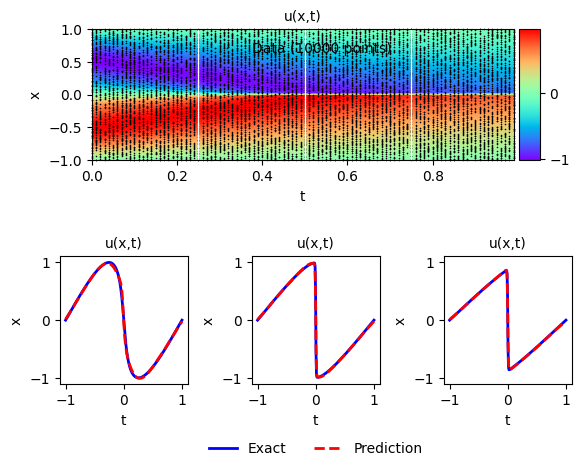

In [23]:
solutionplot(u_pred,X_treino_nu.cpu().detach().numpy(),U_treino_nu)